# The Renormalization Group (RG) method #
##  for weakly nonlinear oscillator equations ##

Support material for the book __Perturbation Methods from a Backward Error Point of View__ by Robert M. Corless and Nicolas Fillion, in preparation.

This section of the book follows the method given in the very nice 2012 SIAM Review (Education) paper ["The Renormalization Group: A Perturbation Method for the Graduate Curriculum"](https://doi.org/10.1137/080731967) by Eleftherios Kirkinis. 


Copyright (c) 2024 Robert M. Corless

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.



## Preliminaries ##

First, some setup: a macro to allow easy typing of $\varepsilon$, and some helper utilities.

In [1]:
starting_time := time():
macro( ep = varepsilon );

kilobytes used=1729, alloc=5424, time=0.30

$$\varepsilon$$

The following helper routine makes life somewhat easier.

"partsol" finds a particular solution of $y'' + y = Q \exp(i t\omega)$ more quickly than dsolve does, and leaves the answer in the form $P\exp(i t\omega)$.


In [2]:
partsol := proc( Q, x, omega)
	local k, m, mdeg, p;
	m := degree( Q, x );
	if omega^2=1 then
		mdeg := m+1;
	else
		mdeg := m;
	end if;
	P := add(p[k]*x^k,k=0..mdeg);
	zr := collect( Q - (1-omega^2)*P - 
	              2*I*omega*diff(P,x) - diff(P,x,x), x);
	eqs := PolynomialTools:-CoefficientList(zr,x);
	sol := solve(convert(eqs,set), {seq(p[k],k=0..mdeg)} );
	return eval( eval(P, sol), p[0]=0 );
end proc:

## Input parameters: the DE and the order we work to ##

This example is the lengthening pendulum equation.  You can change it to be whatever you want.

In [3]:
y := 'y':
residual := 'residual':
WeaklyNonlinear := (1+ep*t)*diff(y(t), t, t) + 2*ep*diff(y(t), t) + y(t)

$$\left(\varepsilon  t +1\right) \left(\frac{d^{2}}{d t^{2}}y \left(t \right)\right)+2 \varepsilon  \left(\frac{d}{d t}y \left(t \right)\right)+y \left(t \right)$$

Choose the order to work to.  We will get the solution to $O(\varepsilon^{N+1})$, first with secularity, and then without.  We have taken $N$ as high as $16$, where the total process took about twenty-six minutes with our original, specialized code.  We have since replaced that specialized code because it was too fragile; changing the differential equation caused it to break very easily.  The timing is now longer: for $N=8$ it takes 50 seconds, or less than a minute. For N=12 it takes 336 seconds, or five and a half minutes. For $N=16$ the code now takes 35 minutes.

In [4]:
N := 3;  # Taking N=0 breaks some assumptions below, so choose N > 0.

                                    N := 3

$$3$$

## Compute the naive secular solution ##

In [5]:
ys := Array(0 .. N): # Placeholder for secular solution terms
rs := Array(0 .. N): # Placeholder for residuals

The initial approximation is a solution to $y'' + y = 0$, which we write in complex conjugate form.

In [6]:
ys[0] := A*exp(phi*I)*exp(t*I) + A*exp(-I*phi)*exp(-I*t);

$$A \,{\mathrm e}^{\mathrm{I} \phi} {\mathrm e}^{\mathrm{I} t}+A \,{\mathrm e}^{\mathrm{-I} \phi} {\mathrm e}^{\mathrm{-I} t}$$

In [7]:
zs := ys[0]: # Current secular solution in the variable "zs"

$$A \,{\mathrm e}^{\mathrm{I} \phi} {\mathrm e}^{\mathrm{I} t}+A \,{\mathrm e}^{\mathrm{-I} \phi} {\mathrm e}^{\mathrm{-I} t}$$

Build up the regular perturbation solution using our fast "particular solution" solver. We ignore initial conditions entirely; we will fix them up at the end if we need to.

Regular perturbation solves the linearized system $y'' + y =$ the negative of the coefficient of $\varepsilon^k$ in the residual of $y_{k-1}$.


In [8]:
loop_start := time():
times := Array(1 .. N):
for k to N do
    residuals[k - 1] := combine(expand(
                          coeff(eval(WeaklyNonlinear, y(t) = zs), ep, k)),
                          exp);
    if type(residuals[k - 1], `+`) then
        newans := 0;
        for trm in op(residuals[k - 1]) do
            expco := eval(trm, exp = 1);
            exptrm := simplify(trm/expco) assuming A>0, phi::real ;
            if not match(exptrm = 'exp((t + theta)*omega__1*I)', t, 's') then
                error "Unexpected form of a term in the residual:", exptrm;
            else
                newans := newans + partsol(op(eval([expco, t, omega__1], s)))*eval(exp((t + theta)*omega__1*I), s);
            end if;
        end do;
    end if;
    ys[k] := -newans;
    zs := zs + ys[k]*ep^k;
    times[k] := time();
end do:

Always compute the final residual.  Here, we are just computing the leading coefficient of the final residual; that is enough for us here.

In [9]:
residuals[N] := CodeTools:-Usage(
  map(LargeExpressions:-Veil[K], 
  series(leadterm(
    combine(expand(eval(WeaklyNonlinear, y(t) = zs)), exp)),
       ep)
     )                          );

memory used=7.83MiB, alloc change=0 bytes, cpu time=93.00ms, real time=96.00ms, gc time=0ns

$$\frac{K_{1}}{384} \varepsilon^{4}$$

The secular term has $\exp(i t)$ in it, but might also get mixed up with $\exp(i(t+\phi))$ or $\exp(i(t-\phi))$.  So we get them all.

In [10]:
saecular := coeff(zs, exp(t*I)) 
  + exp(phi*I)*coeff(zs, exp((t + phi)*I)) 
  + exp(-I*phi)*coeff(zs, exp((t - phi)*I)):

We clean this up a bit.

In [11]:
saecular := (collect(saecular, ep, m -> Re(m) + Im(m)*I) 
             assuming (0 < t, A>0, phi::real)):
saecular := (simplify(saecular) assuming (0 < t, A > 0, phi::real)):
saecular := collect(saecular, ep, factor):

## Compute the secular series ##

The _secular series_ is available from this term.

In [12]:
yA := collect(saecular/(A*exp(phi*I)), ep):
yA := (collect(yA, ep, m -> Re(m) + Im(m)*I) 
  assuming (0 < t, A>0, phi::real)):
yA := combine(yA, trig):

## Express A in terms of R ##
Now we will need to invert $R = A y_A$ and the best way is by a real equation.  $R$ is real and $A > 0$ by our choice of $\phi$.  The equation that we will solve is $f(R,A,\varepsilon) = 0$ where $f(R,A,\varepsilon) = R^2 - A^2(\Re(y_A)^2 + \Im(y_A)^2)$.

In [13]:
rhosq := series(evalc(Re(yA)^2 + Im(yA)^2), ep, N + 1):
rhosq := map(simplify, rhosq):
rhosq := convert(rhosq, polynom):
freqn := R^2 - A^2*rhosq:

kilobytes used=13472, alloc=14427, time=1.34

We will solve this perturbatively for $A = g(R,\varepsilon)$.  We need the derivative, for our regular perturbation method.

In [14]:
eval(diff(freqn, R), ep = 0);

$$2 R$$

So our inverse operator is $\frac{1}{2R}$.  Now check that our initial approximation A=R is accurate enough:

In [15]:
series(leadterm(eval(freqn, A = R)), ep);

$$\frac{3 R^{2} t}{2} \varepsilon$$

So $A =  R + O(\varepsilon)$ is a good initial approximation.
Let's use the array "Eh" to represent our terms in the $A$ expansion.

In [16]:
Eh := Array(0 .. N): # get them one by one
residEh := Array(0 .. N): # keep the residuals as well

Our initial approximation:

In [17]:
Eh[0] := R:
Ehz := Eh[0]: # Running solution

$$R$$

Now we use our basic perturbation algorithm to find $A$ in terms of $R$, $\varepsilon$, and $t$.

In [18]:
for k to N do
    residEh[k - 1] := coeff(map(simplify, series(eval(freqn, A = Ehz), ep, k + 2)), ep, k);
    Eh[k] := residEh[k - 1]*ep^k/(2*R);
    Ehz := Ehz + Eh[k];
end do:

Check the final residual: (We don't want to look at the leading coefficient, which will be ugly, but we do want to know the order: so we Veil the coefficient)

In [19]:
residEh[N] := CodeTools:-Usage(
  map(LargeExpressions:-Veil[K], 
  map(simplify, 
  series(eval(freqn, A = Ehz), ep, N + 2)
     )
     )                        );

memory used=0.76MiB, alloc change=0 bytes, cpu time=0ns, real time=3.00ms, gc time=0ns

$$\frac{9 K_{2}}{1024} \varepsilon^{4}+K_{3} \varepsilon^{5}$$

In [20]:
yA := convert(yA, polynom): # The series data structure can be inconvenient
# Maple's internal series data structure is a bit hard to handle sometimes.
coeff( yA, ep, 1 ); # Let's look at the first term.

                               -1/4 I t  - 3/4 t

$$-\frac{\mathrm{I} t^{2}}{4}-\frac{3 t}{4}$$

## Reverse Engineering the Amplitude and Phase DEs ##

The real part of $\dot{y}_A/y_A$ is $\dot{R}/R$, and this is crucial for the renormalization process.

In [21]:
reyAtyA := (Re(diff(yA, t)/yA) assuming (0 < t, 0 < ep, 0 < A, phi::real)):
series(eval(reyAtyA, A = Ehz), ep, N + 1):
simplify(%):
slowRderiv := R*convert(%,polynom);

$$R \left(-\frac{3 \varepsilon}{4}+\frac{3 t \,\varepsilon^{2}}{4}+\left(-\frac{3 t^{2}}{4}-\frac{3}{64}\right) \varepsilon^{3}\right)$$

Now we convert that _expression_ into a _procedure_ which Maple will be able to use to differentiate the function $R(t)$.

In [22]:
`diff/R` := codegen[makeproc](
  eval(slowRderiv*'diff'('expr', 'var'), R = R(expr)), 
  parameters = [expr, var]);

proc (expr, var) R(expr)*(-3/4*varepsilon+3/4*t*varepsilon^2+(-3/4*t^2-3/64)*varepsilon^3)*diff(expr,var) end proc

Now test that Maple knows what the derivative of $R(t)$ is.

In [23]:
diff( R(t), t );

$$R \left(t \right) \left(-\frac{3 \varepsilon}{4}+\frac{3 t \,\varepsilon^{2}}{4}+\left(-\frac{3 t^{2}}{4}-\frac{3}{64}\right) \varepsilon^{3}\right)$$

Now do the same for the $\theta$ equation

In [24]:
ImyAtyA := (Im(diff(yA, t)/yA) assuming (0 < t, 0 < ep, 0 < A, phi::real )):
ImyAtyA := series(eval(ImyAtyA, A = Ehz), ep, N + 1):
ImyAtyA := simplify(ImyAtyA):
ImyAtyA := convert(ImyAtyA, polynom):
`diff/theta` := codegen[makeproc](
  eval(ImyAtyA*'diff'('expr', 'var'), R = R(expr)), 
  parameters = [expr, var]):

In [35]:
eval(`diff/theta`);

proc (expr, var) (-1/2*varepsilon*t+(3/8*t^2-3/32)*varepsilon^2+(-5/16*t^3+9/64*t)*varepsilon^3)*diff(expr,var) end proc

In [25]:
diff( theta(t), t );

$$-\frac{\varepsilon  t}{2}+\left(\frac{3 t^{2}}{8}-\frac{3}{32}\right) \varepsilon^{2}+\left(-\frac{5}{16} t^{3}+\frac{9}{64} t \right) \varepsilon^{3}$$

## Finding the Renormalized Solution ##

We are now in a position to re-do the perturbation computation, starting from our improved initial approximation.  This time, there will be no secular terms.

In [26]:
SHOlveTerm := proc( expr, var )
	local A, la, omega, phase;
	description "Solve y''+y=expr";
	if type( expr, `+` ) then
		return map( procname, expr, var );
	elif match( expr=A*cos(omega*var+phase), var, 'la' ) then
		if eval(omega^2,la)=1 then
			error "Resonant term encountered", expr, var;
		else
			return eval( A*cos(omega*var+phase)/(1-omega^2), la );
		end if;
	elif match( expr=A*sin(omega*var+phase), var, 'la' ) then
		if eval(omega^2,la)=1 then
			error "Resonant term encountered", expr, var;
		else
			return eval( A*sin(omega*var+phase)/(1-omega^2), la );
		end if;
	else
		error "Unexpected kind of term", expr, var;
	end if
end proc:

In [27]:
yr := Array(0 .. N):
rr := Array(0 .. N):
T := t + theta(t):
yr[0] := 2*R(t)*cos(T):
zr := yr[0]: # Our running solution.

$$2 R \left(t \right) \cos \left(t +\theta \left(t \right)\right)$$

This is just a regular expansion, but starting from our initial approximation with all its information about the secular terms hidden in its differentiation rules.

The fundamental assumptions: there will be no resonant terms, and each R(t) and theta(t) can be treated as constant (their derivatives are higher order in epsilon).

In [28]:
rentimes := Array(0 .. N):
rentimes[0] := time():
for k to N do
    rr[k - 1] := coeff(series(eval(WeaklyNonlinear, y(t) = zr), ep, k + 1),
                       ep, k);
    rr[k - 1] := combine(rr[k - 1], trig);
    rr[k-1] := eval(rr[k-1], [R(t)=RR,theta(t)=Theta]);
    yr[k] := SHOlveTerm( -rr[k-1], t );
    yr[k] := eval(yr[k], [RR=R(t),Theta=theta(t)]);
    zr := zr + ep^k*yr[k];
    rentimes[k] := time();
end do:

In [29]:
fullrrN := eval(WeaklyNonlinear, y(t) = zr):

Now, we _really care_ what the full residual is, not just the leading term in $\varepsilon$.  The computation won't be correct if the leading term is not $O(\varepsilon^{N+1})$, so we should check that, too, but we also care about what the full residual is.

In [30]:
collect( 
  convert(map( combine, series( fullrrN, ep, N+3 ), trig),polynom),
  ep,
  LargeExpressions:-Veil[K]
       ) assuming ep>0, R(t)>0, t>0, theta(t)>0;

$$-\frac{1}{512} K_{4} \varepsilon^{5}+\frac{1}{512} K_{5} \varepsilon^{4}$$

In [31]:
zr;

$$2 R \left(t \right) \cos \left(t +\theta \left(t \right)\right)$$

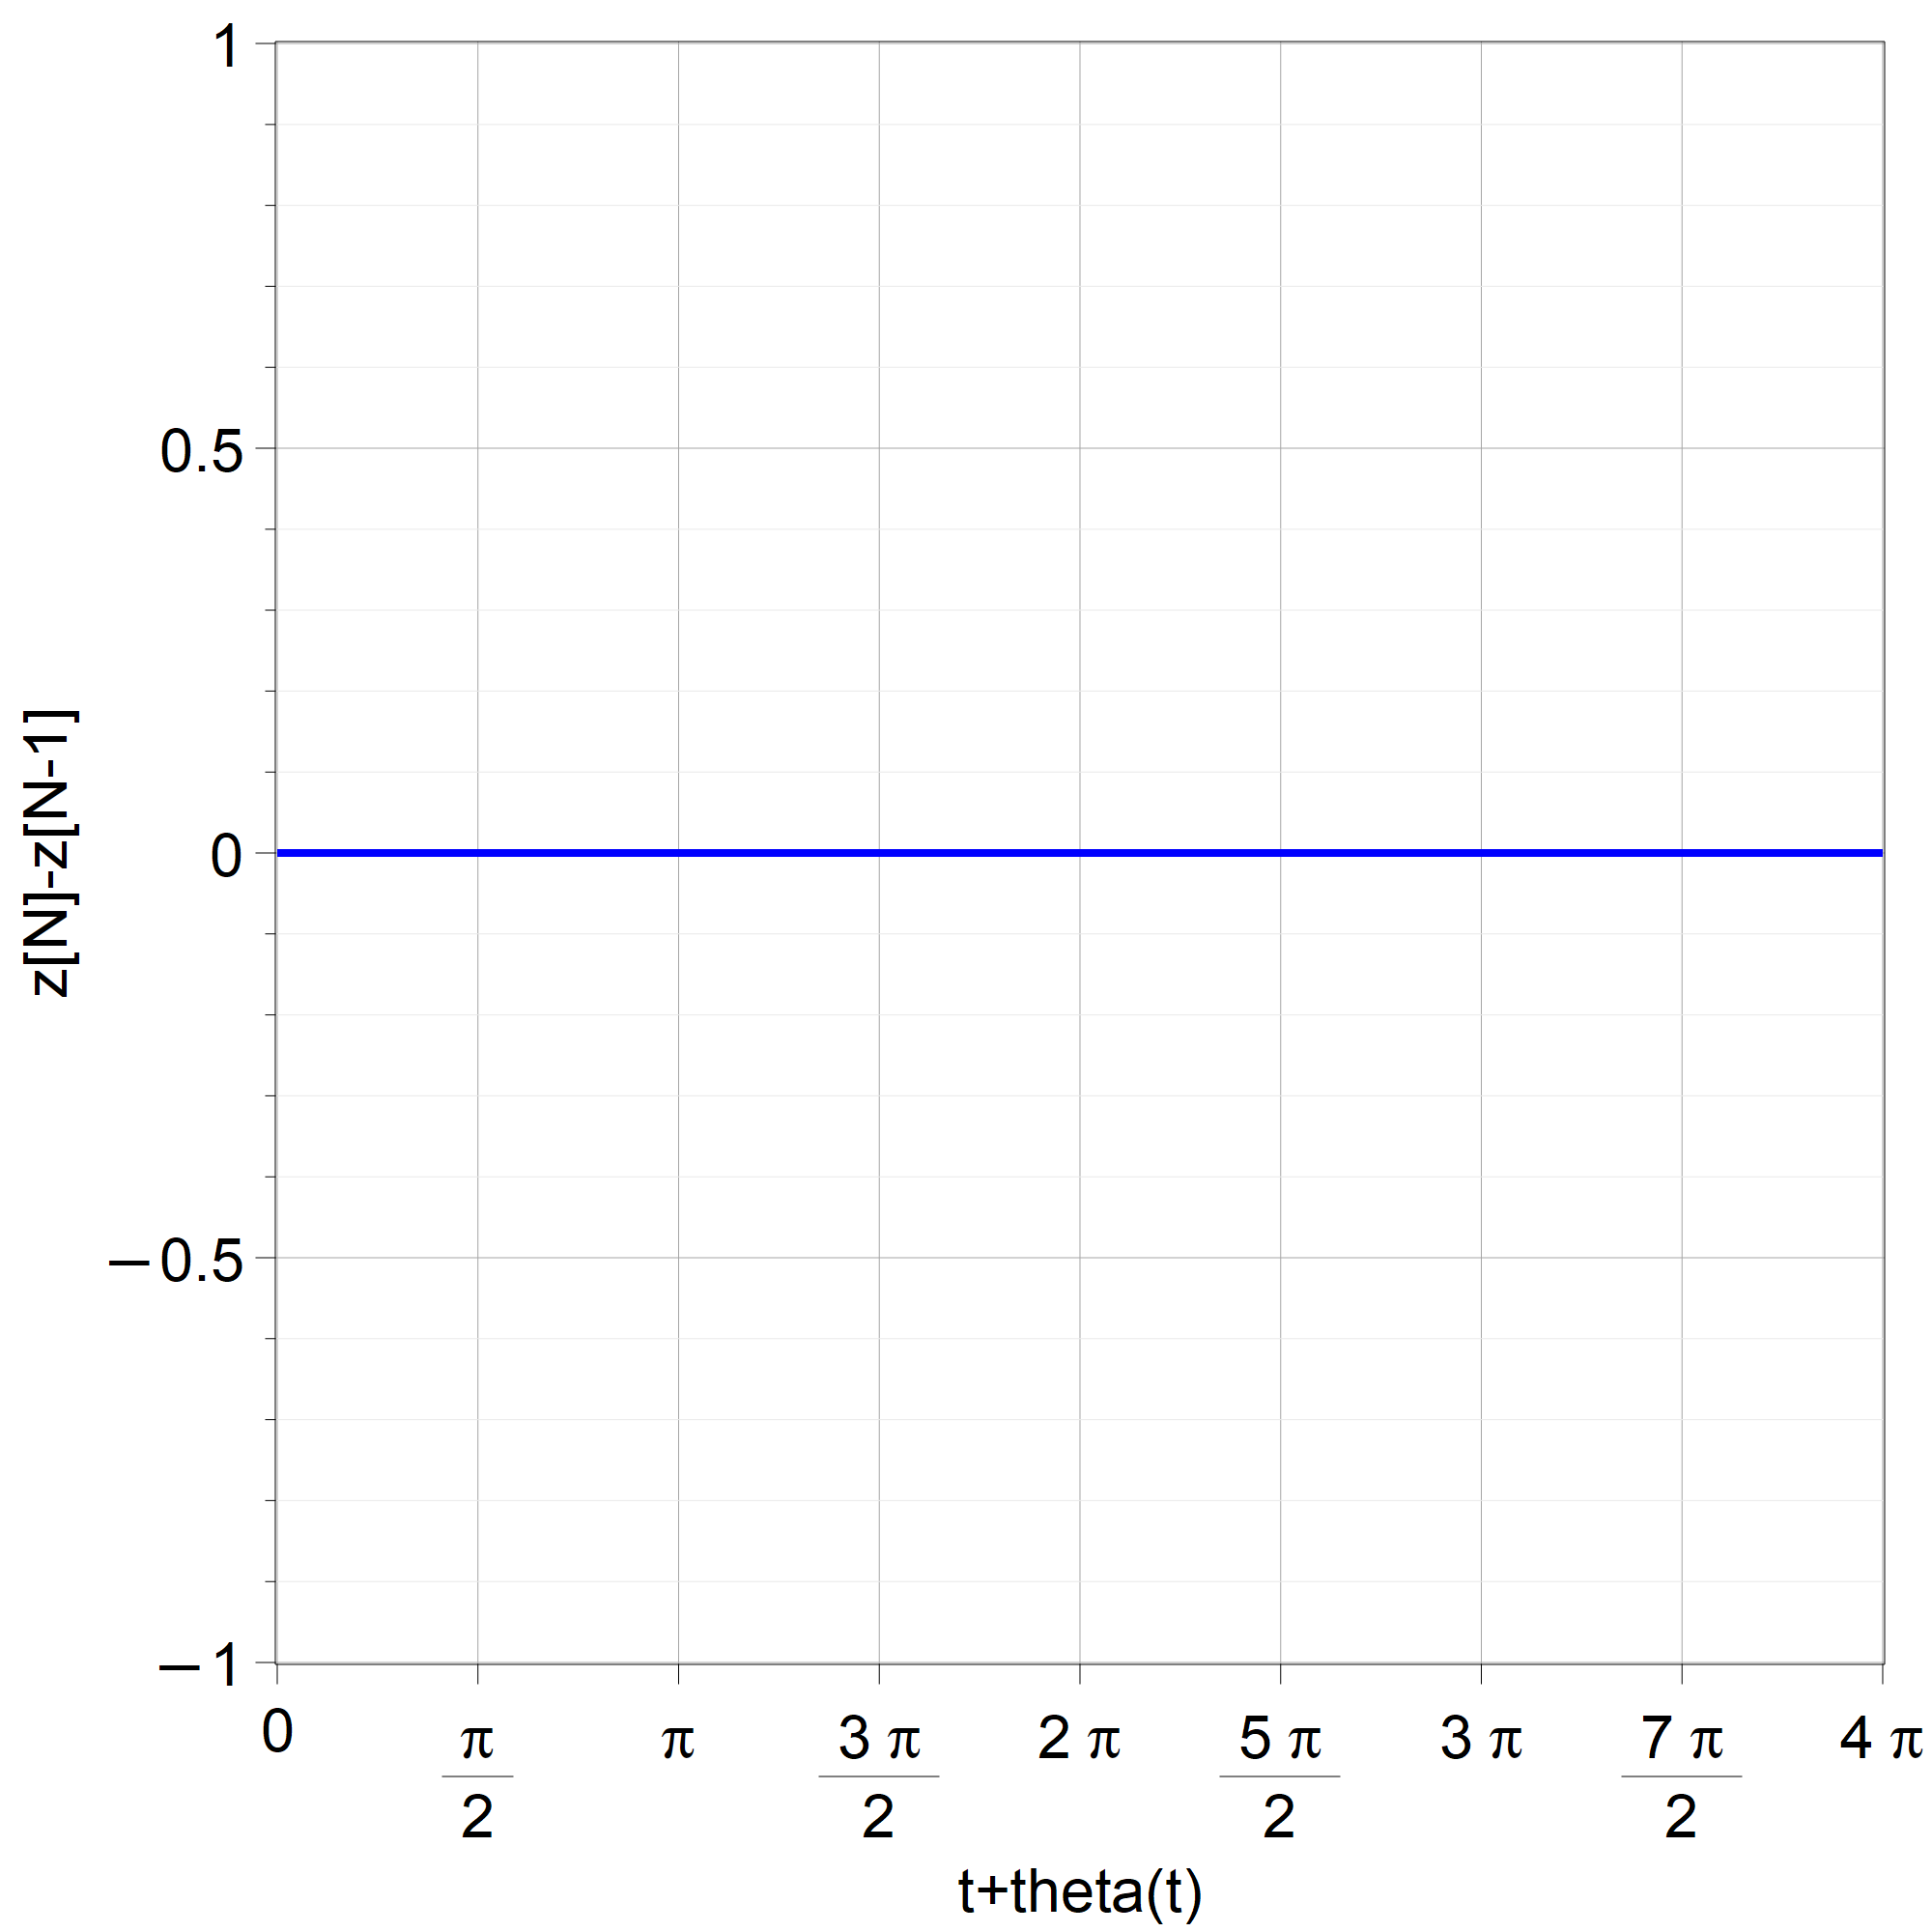

In [32]:
zn := zr - coeff(zr,ep,N)*ep^N:
plot( eval( ep^N*coeff(zr,ep,N), [R(t)=1/2, theta(t)=0,e=0.4]),
      t=0..4*Pi, colour=blue, 
      labels=[typeset( t+theta(t)),typeset('z[N]-z[N-1]' )],
      thickness=8, gridlines=true, 
      tickmarks=[spacing(Pi/2),default],
      labeldirections = [horizontal, vertical], 
      font = ["Arial", 48], labelfont = ["Arial", 48], size=[2000,2000] 
    );

In [33]:
time_taken := time() - starting_time;

$$ 1.203$$

In [34]:
time_taken/60;

$$ 0.0200500000000000$$